Installing **Required Libraries**

In [1]:
%pip install --upgrade pip
%pip install cmake
%pip install face_recognition
%pip install tqdm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


Importing **Libraries** to setup the environment

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import cv2 as cv 
import os
import shutil 
import face_recognition as fr
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import sklearn.metrics as smt
import seaborn as sns
sns.set_style('darkgrid')

print(" libraries are loaded")

 libraries are loaded


loading the dataset

In [3]:
df=pd.read_csv("archives\Dataset.csv")
df

,id,label
0,Robert Downey Jr_87.jpg,Robert Downey Jr
1,Lisa Kudrow_64.jpg,Lisa Kudrow
2,Ellen Degeneres_34.jpg,Ellen Degeneres
3,Billie Eilish_3.jpg,Billie Eilish
4,Hrithik Roshan_35.jpg,Hrithik Roshan
...,...,...
2557,Jessica Alba_90.jpg,Jessica Alba
2558,Elizabeth Olsen_27.jpg,Elizabeth Olsen
2559,Elizabeth Olsen_59.jpg,Elizabeth Olsen
2560,Henry Cavill_7.jpg,Henry Cavill


Understanding the dataset

In [4]:
df.head( )

,id,label
0,Robert Downey Jr_87.jpg,Robert Downey Jr
1,Lisa Kudrow_64.jpg,Lisa Kudrow
2,Ellen Degeneres_34.jpg,Ellen Degeneres
3,Billie Eilish_3.jpg,Billie Eilish
4,Hrithik Roshan_35.jpg,Hrithik Roshan


In [5]:
df.label.value_counts().to_frame()

,count
label,
Brad Pitt,120
Vijay Deverakonda,115
Robert Downey Jr,113
Hugh Jackman,112
Jessica Alba,108
Henry Cavill,106
Natalie Portman,105
Priyanka Chopra,102
Hrithik Roshan,101


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2562 non-null   object
 1   label   2562 non-null   object
dtypes: object(2)
memory usage: 40.2+ KB


In [7]:
df.describe()

,id,label
count,2562,2562
unique,2562,31
top,Claire Holt_29.jpg,Brad Pitt
freq,1,120


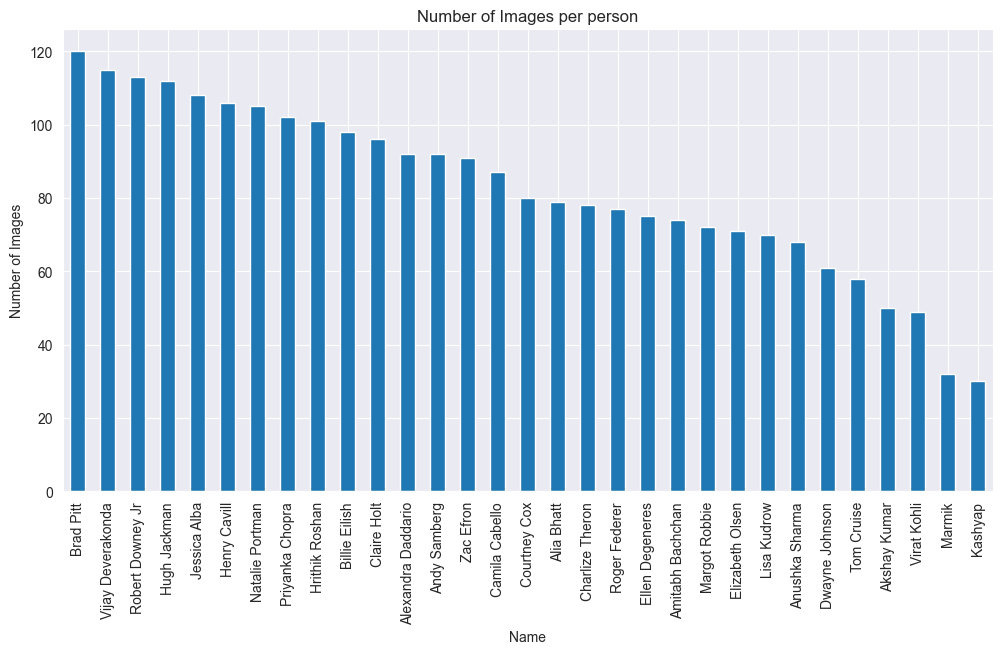

In [8]:
# Plot distribution of images per Person
df['label'].value_counts().plot(kind='bar', figsize=(12,6))
plt.title('Number of Images per person')
plt.xlabel('Name')
plt.ylabel('Number of Images')
plt.show()

encoding the images to fit into the model

In [9]:
from tqdm import tqdm
import os
import face_recognition as fr

def encode_images(df):
    dir = r"archives\Original Images\Original Images"
    face_encodings_list = []
    labels_list = []

    # Wrap the loop with tqdm for progress tracking
    for path, label in tqdm(df.values, total=len(df), desc="Encoding Images"):
        img_path = os.path.join(dir, label, path)
        image = fr.load_image_file(img_path)
        face_encodings = fr.face_encodings(image)

        if face_encodings:
            face_encoding = face_encodings[0]
            face_encodings_list.append(face_encoding)
            labels_list.append(label)

    return face_encodings_list, labels_list

# Run the function with progress tracking
x, y = encode_images(df)


Encoding Images: 100%|██████████| 2562/2562 [56:08<00:00,  1.31s/it]  


Model Training

In [10]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.15 , stratify = y  , random_state = 42)

Model Fitting

In [11]:
knn_model =  neighbors.KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', weights='distance')

In [12]:
knn_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance')

Model Evaluation

In [13]:
knn_model.score(x_train, y_train)

1.0

In [14]:
y_pred = knn_model.predict(x_test)
precision = smt.precision_score(y_test, y_pred, average='weighted')
recall = smt.recall_score(y_test, y_pred, average='weighted')
f1 = smt.f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


<Axes: >

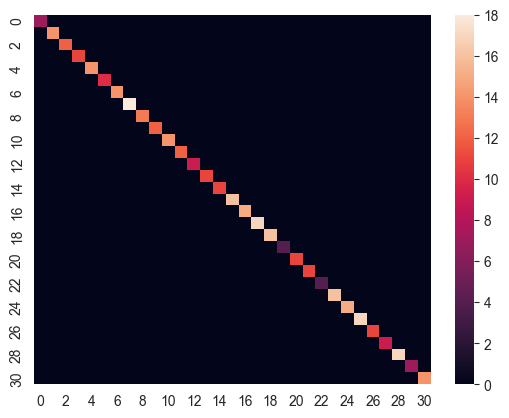

In [15]:
conf_matrix = smt.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix)

Prediction 

In [16]:
def show_image(image, x=10, y=8, bgr=False):
    plt.figure(figsize=(x, y))

    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    elif len(image.shape) == 3:
        if bgr:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.imshow(image)

    plt.xticks([])
    plt.yticks([])
    plt.show()

In [17]:
def predict_and_visualize(image_path):
    # Read the image
    image = cv.imread(image_path)
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_height, image_width = image.shape[:2]

    # Predict
    face_locations = fr.face_locations(rgb_image)
    face_encodings = fr.face_encodings(rgb_image, face_locations)

    # Visualize
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):

        matches = knn_model.kneighbors([face_encoding], n_neighbors=1)
        name = knn_model.predict([face_encoding])[0] if matches[0][0][0] < 0.5 else "Unknown"
        
        cv.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
        font_scale = image_width / 700.0  
        text_position = (left, bottom + int(image_height * 0.06)) 
        cv.putText(image, name, text_position, cv.FONT_HERSHEY_DUPLEX, font_scale, (0, 255, 0), 2)

    show_image(image, bgr=True)

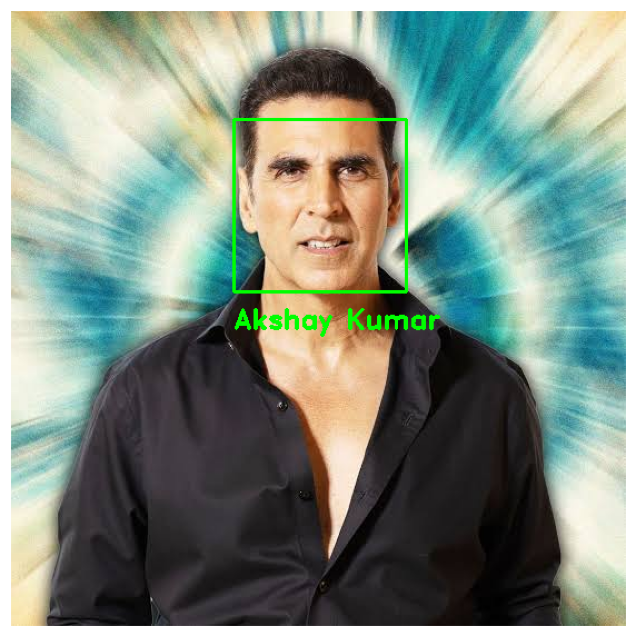

In [18]:
img = 'img_test002.jpg'
predict_and_visualize(img)

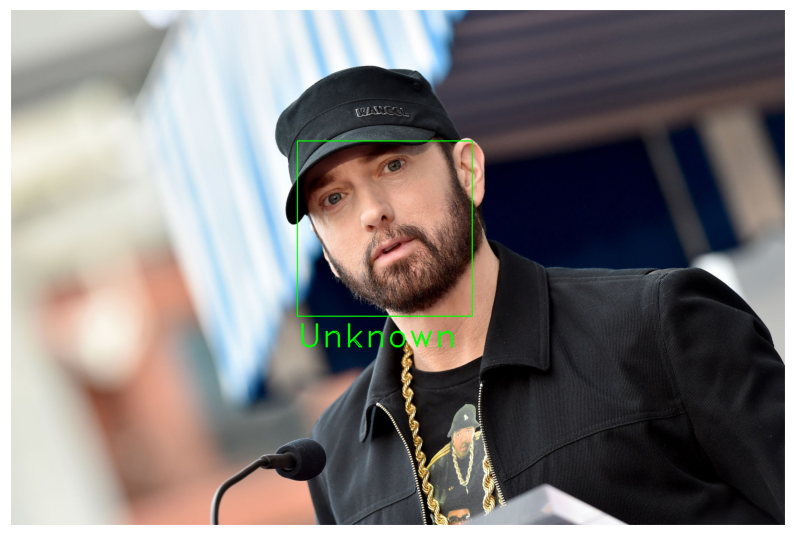

In [19]:
img = 'img_test.jpg'
predict_and_visualize(img)

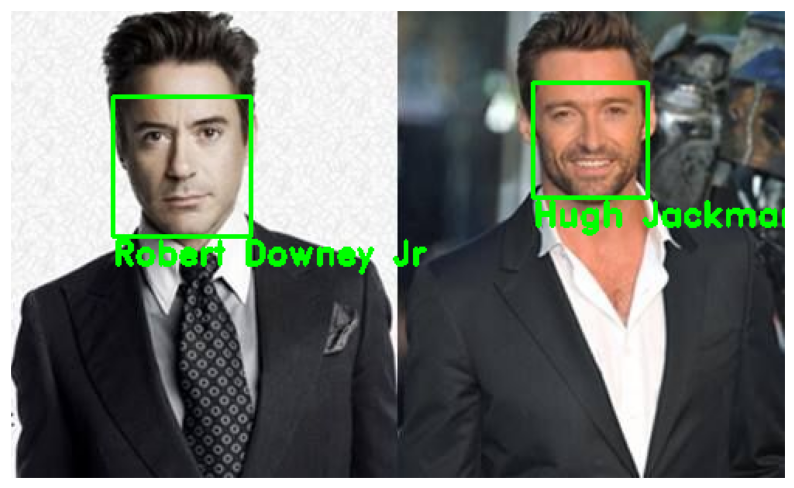

In [20]:
img = 'img_test003.jpg'
predict_and_visualize(img)

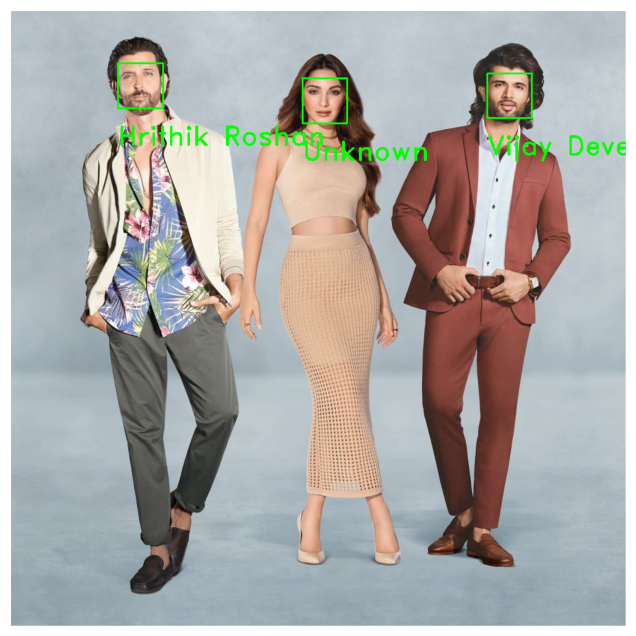

In [24]:
img = 'img_test004.jpg'
predict_and_visualize(img)

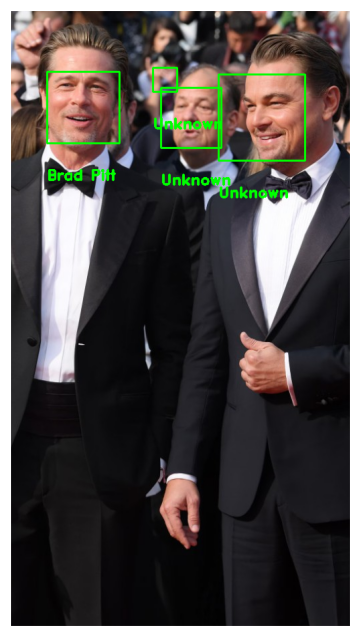

In [26]:
img = 'final-test-001.jpg'
predict_and_visualize(img)